<div align = "center">

# **Modelo de Riesgo Colectivo - Convolución Final**
## **Pérdida Agregada del Portafolio**

</div>

Este notebook implementa la convolución de las 4 distribuciones de pérdida agregada por cobertura (PPD, PPH, PTH, RC) para obtener la distribución de pérdida agregada total del portafolio.


## Configuración inicial

In [13]:
# Librerías necesarias
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(viridis)
library(scales)
library(RColorBrewer)

# Configuración de gráficos
theme_set(theme_minimal(base_size = 16))

# Crear directorio de salida si no existe
if (!dir.exists("../data/output")) {
  dir.create("../data/output", recursive = TRUE)
}

print("Configuración completada")

[1] "Configuración completada"


## Cargar datos de FFT

In [14]:
# Cargar distribuciones de pérdida agregada por cobertura (FFT)
cat("Cargando distribuciones de pérdida agregada por cobertura...\n")

fft_ppd <- read.csv("../data/processed/prob_agregada_ppd_fft.csv")
fft_pph <- read.csv("../data/processed/prob_agregada_pph_fft.csv")
fft_pth <- read.csv("../data/processed/prob_agregada_pth_fft.csv")
fft_rc <- read.csv("../data/processed/prob_agregada_rc_fft.csv")

# Verificar que todos tengan la misma longitud
longitudes <- c(nrow(fft_ppd), nrow(fft_pph), nrow(fft_pth), nrow(fft_rc))
cat("Longitudes de los datasets:\n")
cat(sprintf("PPD: %d puntos\n", longitudes[1]))
cat(sprintf("PPH: %d puntos\n", longitudes[2]))
cat(sprintf("PTH: %d puntos\n", longitudes[3]))
cat(sprintf("RC: %d puntos\n", longitudes[4]))

if (length(unique(longitudes)) == 1) {
  cat("✓ Todas las distribuciones tienen la misma longitud\n")
} else {
  stop("ERROR: Las distribuciones tienen longitudes diferentes")
}

# Mostrar estadísticas básicas
cat("\nEstadísticas básicas:\n")
cat(sprintf("Rango: $%s a $%s\n", 
           format(min(fft_ppd$x), big.mark = ","), 
           format(max(fft_ppd$x), big.mark = ",")))
cat(sprintf("Paso: $%s\n", format(fft_ppd$x[2] - fft_ppd$x[1], big.mark = ",")))

print("Datos cargados exitosamente")

Cargando distribuciones de pérdida agregada por cobertura...
Longitudes de los datasets:
PPD: 50001 puntos
PPH: 50001 puntos
PTH: 50001 puntos
RC: 50001 puntos
✓ Todas las distribuciones tienen la misma longitud

Estadísticas básicas:
Rango: $0 a $5e+08
Paso: $10,000
[1] "Datos cargados exitosamente"


## Cargar datos de severidad

In [15]:
# Cargar distribuciones de severidad discretizadas
cat("Cargando distribuciones de severidad...\n")

prob_severidad_ppd <- read.csv("../data/processed/prob_severidad_ppd.csv")
prob_severidad_pph <- read.csv("../data/processed/prob_severidad_pph.csv")
prob_severidad_pth <- read.csv("../data/processed/prob_severidad_pth.csv")
prob_severidad_rc <- read.csv("../data/processed/prob_severidad_rc.csv")

# Cargar metadata de severidad
metadata_severidad <- read.csv("../data/processed/severidad_discreta_metadata.csv")

# Mostrar información
cat("\nInformación de severidad:\n")
for (i in 1:nrow(metadata_severidad)) {
  cat(sprintf("%s: %s (%s) - %d puntos\n", 
              metadata_severidad$cobertura[i], 
              metadata_severidad$distribucion[i], 
              metadata_severidad$parametros[i], 
              metadata_severidad$numero_puntos[i]))
}

print("Datos de severidad cargados exitosamente")

Cargando distribuciones de severidad...


Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../data/processed/severidad_discreta_metadata.csv'”



Información de severidad:
PPD: gamma (α=1.8460, β=0.0000) - 50000 puntos
PPH: gamma (α=1.9422, β=0.0000) - 50000 puntos
PTH: gamma (α=0.9403, β=0.0000) - 50000 puntos
RC: lognormal (μ=14.1863, σ=0.8105) - 50000 puntos
[1] "Datos de severidad cargados exitosamente"


## Función de convolución usando FFT

In [16]:
# Función para convolución de dos distribuciones usando FFT
convolucion_fft <- function(pmf1, pmf2, normalize = TRUE) {
  # Determinar tamaño para FFT (potencia de 2)
  n_total <- length(pmf1) + length(pmf2) - 1
  n_fft <- 2^ceiling(log2(n_total))
  
  # Rellenar con ceros
  pmf1_padded <- c(pmf1, rep(0, n_fft - length(pmf1)))
  pmf2_padded <- c(pmf2, rep(0, n_fft - length(pmf2)))
  
  # Convolución usando FFT
  fft1 <- fft(pmf1_padded)
  fft2 <- fft(pmf2_padded)
  conv_fft <- fft1 * fft2
  
  # FFT inversa
  result <- Re(fft(conv_fft, inverse = TRUE)) / n_fft
  
  # Tomar solo la parte relevante
  result <- result[1:n_total]
  
  # Asegurar no negatividad
  result <- pmax(result, 0)
  
  # Normalizar si se solicita
  if (normalize) {
    result <- result / sum(result)
  }
  
  return(result)
}

# Función para convolución múltiple
convolucion_multiple <- function(pmf_list, nombres = NULL) {
  if (is.null(nombres)) {
    nombres <- paste0("Dist", 1:length(pmf_list))
  }
  
  cat("Realizando convolución múltiple...\n")
  
  # Comenzar con la primera distribución
  resultado <- pmf_list[[1]]
  cat(sprintf("Iniciando con %s (%d puntos)\n", nombres[1], length(resultado)))
  
  # Convolucionar con las demás
  for (i in 2:length(pmf_list)) {
    cat(sprintf("Convolución con %s...\n", nombres[i]))
    resultado <- convolucion_fft(resultado, pmf_list[[i]])
    cat(sprintf("Resultado: %d puntos\n", length(resultado)))
  }
  
  cat("Convolución múltiple completada\n")
  return(resultado)
}

print("Funciones de convolución definidas")

[1] "Funciones de convolución definidas"


## Convolución de las 4 distribuciones

In [17]:
# Preparar las PMF para convolución
pmf_list <- list(
  PPD = fft_ppd$pmf,
  PPH = fft_pph$pmf,
  PTH = fft_pth$pmf,
  RC = fft_rc$pmf
)

# Realizar convolución múltiple
cat("═══════════════════════════════════════════════════════════════════════════\n")
cat("                    CONVOLUCIÓN DE PÉRDIDA AGREGADA TOTAL                 \n")
cat("═══════════════════════════════════════════════════════════════════════════\n")

pmf_total <- convolucion_multiple(pmf_list, names(pmf_list))

# Crear vector de valores x para la distribución total
# El rango se extiende hasta 4 veces el máximo (suma de los máximos)
x_scale <- fft_ppd$x[2] - fft_ppd$x[1]  # Paso
x_vals_total <- (0:(length(pmf_total) - 1)) * x_scale

# Calcular CDF
cdf_total <- cumsum(pmf_total)

# Crear dataframe final
dist_total <- data.frame(
  x = x_vals_total,
  pmf = pmf_total,
  cdf = cdf_total
)

# Mostrar estadísticas
cat("\nEstadísticas de la distribución total:\n")
cat(sprintf("Puntos: %d\n", nrow(dist_total)))
cat(sprintf("Rango: $%s a $%s\n", 
           format(min(dist_total$x), big.mark = ","), 
           format(max(dist_total$x), big.mark = ",")))
cat(sprintf("Suma PMF: %.8f\n", sum(dist_total$pmf)))
cat(sprintf("CDF final: %.8f\n", tail(dist_total$cdf, 1)))

# Percentiles importantes
percentiles <- c(0.90, 0.95, 0.99, 0.999)
cat("\nPercentiles de la pérdida agregada total:\n")
for (p in percentiles) {
  idx <- which(dist_total$cdf >= p)[1]
  valor <- dist_total$x[idx]
  cat(sprintf("P%.1f: $%s\n", p*100, format(valor, big.mark = ",")))
}

cat("═══════════════════════════════════════════════════════════════════════════\n")
print("Convolución completada exitosamente")

═══════════════════════════════════════════════════════════════════════════
                    CONVOLUCIÓN DE PÉRDIDA AGREGADA TOTAL                 
═══════════════════════════════════════════════════════════════════════════
Realizando convolución múltiple...
Iniciando con PPD (50001 puntos)
Convolución con PPH...
Resultado: 100001 puntos
Convolución con PTH...
Resultado: 150001 puntos
Convolución con RC...
Resultado: 200001 puntos
Convolución múltiple completada

Estadísticas de la distribución total:
Puntos: 200001
Rango: $0 a $2e+09
Suma PMF: 1.00000000
CDF final: 1.00000000

Percentiles de la pérdida agregada total:
P90.0: $24,580,000
P95.0: $30,850,000
P99.0: $52,420,000
P99.9: $92,560,000
═══════════════════════════════════════════════════════════════════════════
[1] "Convolución completada exitosamente"


## Exportar datos a data/output/

In [18]:
# Exportar distribuciones individuales de pérdida agregada
cat("Exportando distribuciones individuales...\n")
write.csv(fft_ppd, "../data/output/perdida_agregada_ppd.csv", row.names = FALSE)
write.csv(fft_pph, "../data/output/perdida_agregada_pph.csv", row.names = FALSE)
write.csv(fft_pth, "../data/output/perdida_agregada_pth.csv", row.names = FALSE)
write.csv(fft_rc, "../data/output/perdida_agregada_rc.csv", row.names = FALSE)

# Exportar distribución total del portafolio
cat("Exportando distribución total del portafolio...\n")
write.csv(dist_total, "../data/output/perdida_agregada_total_portafolio.csv", row.names = FALSE)

# Exportar distribuciones de severidad
cat("Exportando distribuciones de severidad...\n")
write.csv(prob_severidad_ppd, "../data/output/severidad_ppd.csv", row.names = FALSE)
write.csv(prob_severidad_pph, "../data/output/severidad_pph.csv", row.names = FALSE)
write.csv(prob_severidad_pth, "../data/output/severidad_pth.csv", row.names = FALSE)
write.csv(prob_severidad_rc, "../data/output/severidad_rc.csv", row.names = FALSE)

# Exportar metadata
write.csv(metadata_severidad, "../data/output/metadata_severidad.csv", row.names = FALSE)

# Crear resumen de percentiles
resumen_percentiles <- data.frame(
  Cobertura = c("PPD", "PPH", "PTH", "RC", "TOTAL"),
  P90 = c(
    fft_ppd$x[which(fft_ppd$cdf >= 0.90)[1]],
    fft_pph$x[which(fft_pph$cdf >= 0.90)[1]],
    fft_pth$x[which(fft_pth$cdf >= 0.90)[1]],
    fft_rc$x[which(fft_rc$cdf >= 0.90)[1]],
    dist_total$x[which(dist_total$cdf >= 0.90)[1]]
  ),
  P95 = c(
    fft_ppd$x[which(fft_ppd$cdf >= 0.95)[1]],
    fft_pph$x[which(fft_pph$cdf >= 0.95)[1]],
    fft_pth$x[which(fft_pth$cdf >= 0.95)[1]],
    fft_rc$x[which(fft_rc$cdf >= 0.95)[1]],
    dist_total$x[which(dist_total$cdf >= 0.95)[1]]
  ),
  P99 = c(
    fft_ppd$x[which(fft_ppd$cdf >= 0.99)[1]],
    fft_pph$x[which(fft_pph$cdf >= 0.99)[1]],
    fft_pth$x[which(fft_pth$cdf >= 0.99)[1]],
    fft_rc$x[which(fft_rc$cdf >= 0.99)[1]],
    dist_total$x[which(dist_total$cdf >= 0.99)[1]]
  ),
  P999 = c(
    fft_ppd$x[which(fft_ppd$cdf >= 0.999)[1]],
    fft_pph$x[which(fft_pph$cdf >= 0.999)[1]],
    fft_pth$x[which(fft_pth$cdf >= 0.999)[1]],
    fft_rc$x[which(fft_rc$cdf >= 0.999)[1]],
    dist_total$x[which(dist_total$cdf >= 0.999)[1]]
  )
)

write.csv(resumen_percentiles, "../data/output/resumen_percentiles.csv", row.names = FALSE)

cat("\nArchivos exportados:\n")
cat("- perdida_agregada_ppd.csv\n")
cat("- perdida_agregada_pph.csv\n")
cat("- perdida_agregada_pth.csv\n")
cat("- perdida_agregada_rc.csv\n")
cat("- perdida_agregada_total_portafolio.csv\n")
cat("- severidad_ppd.csv\n")
cat("- severidad_pph.csv\n")
cat("- severidad_pth.csv\n")
cat("- severidad_rc.csv\n")
cat("- metadata_severidad.csv\n")
cat("- resumen_percentiles.csv\n")

print("Exportación completada")

Exportando distribuciones individuales...


Exportando distribución total del portafolio...
Exportando distribuciones de severidad...

Archivos exportados:
- perdida_agregada_ppd.csv
- perdida_agregada_pph.csv
- perdida_agregada_pth.csv
- perdida_agregada_rc.csv
- perdida_agregada_total_portafolio.csv
- severidad_ppd.csv
- severidad_pph.csv
- severidad_pth.csv
- severidad_rc.csv
- metadata_severidad.csv
- resumen_percentiles.csv
[1] "Exportación completada"


## Gráficos de distribuciones individuales

Datos preparados - 50M: 20004 puntos, 500M: 200004 puntos\n[1] "Gráficos hasta 50M:"


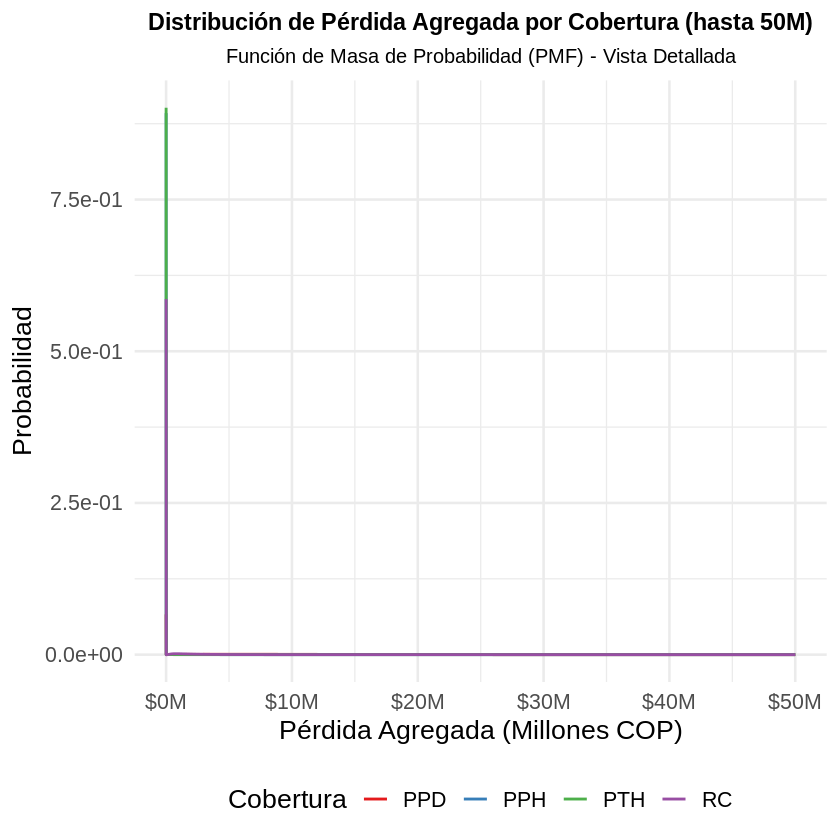

[1] "Gráficos hasta 500M:"


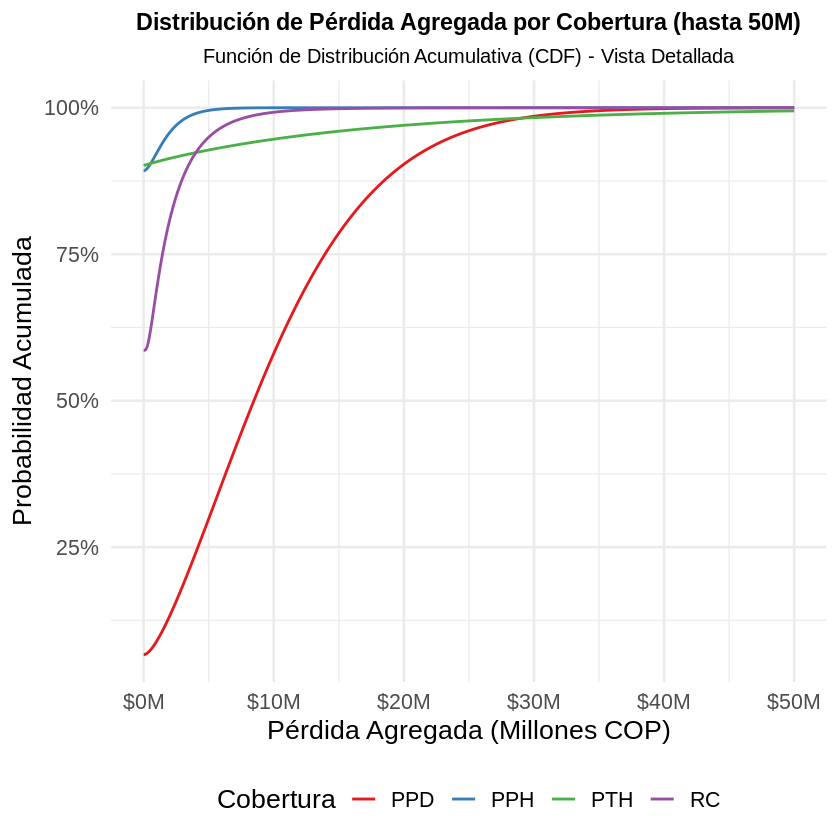

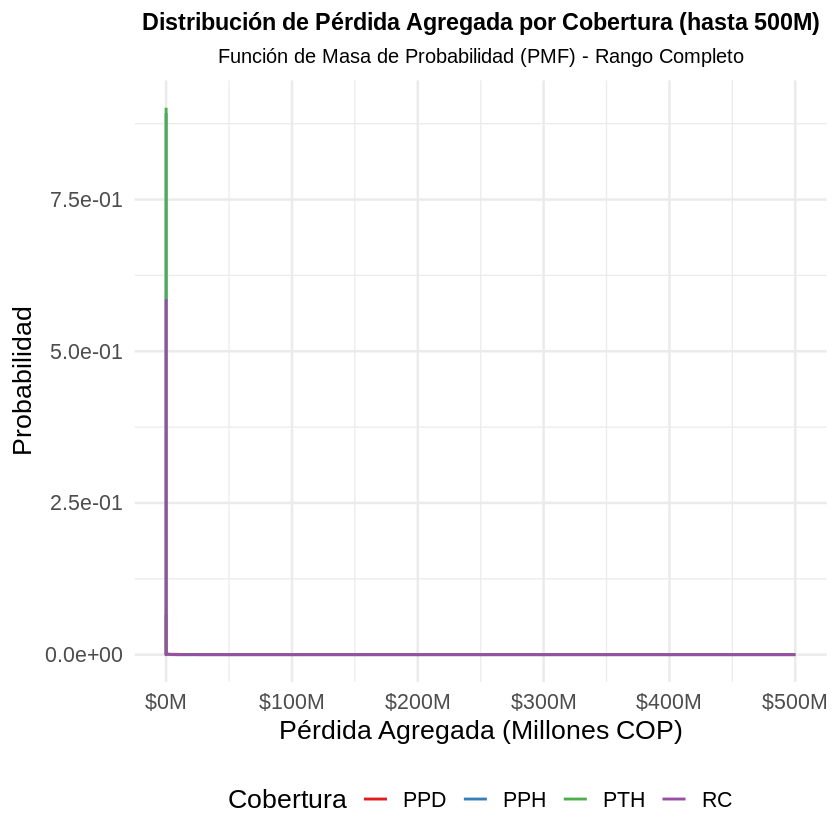

Gráficos por cobertura guardados (versiones 50M y 500M)\n

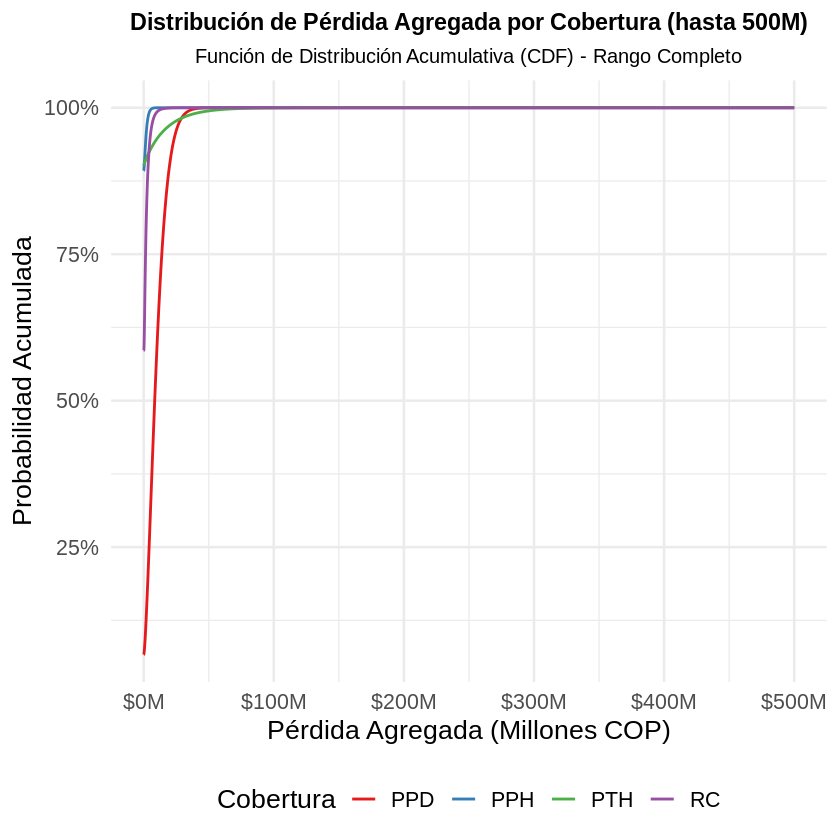

In [19]:
# Preparar datos para gráficos en dos versiones: hasta 50M y hasta 500M
preparar_datos_grafico <- function(data, cobertura, x_max) {
  # Filtrar hasta x_max
  idx_max <- which(data$x <= x_max)
  if (length(idx_max) == 0) idx_max <- 1:nrow(data)
  
  return(data.frame(
    x = data$x[idx_max],
    pmf = data$pmf[idx_max],
    cdf = data$cdf[idx_max],
    cobertura = cobertura
  ))
}

# Preparar datos para gráficos hasta 50 millones (detalle)
datos_grafico_50M <- bind_rows(
  preparar_datos_grafico(fft_ppd, "PPD", 50000000),
  preparar_datos_grafico(fft_pph, "PPH", 50000000),
  preparar_datos_grafico(fft_pth, "PTH", 50000000),
  preparar_datos_grafico(fft_rc, "RC", 50000000)
)

# Preparar datos para gráficos hasta 500 millones (rango completo)
datos_grafico_500M <- bind_rows(
  preparar_datos_grafico(fft_ppd, "PPD", 500000000),
  preparar_datos_grafico(fft_pph, "PPH", 500000000),
  preparar_datos_grafico(fft_pth, "PTH", 500000000),
  preparar_datos_grafico(fft_rc, "RC", 500000000)
)

cat(sprintf("Datos preparados - 50M: %d puntos, 500M: %d puntos\\n", 
           nrow(datos_grafico_50M), nrow(datos_grafico_500M)))

# VERSIÓN 1: GRÁFICOS HASTA 50 MILLONES (DETALLE)

# Gráfico PMF por cobertura - 50M
p1_50M <- ggplot(datos_grafico_50M, aes(x = x, y = pmf, color = cobertura)) +
  geom_line(size = 0.8) +
  scale_color_brewer(type = "qual", palette = "Set1") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = scientific) +
  labs(
    title = "Distribución de Pérdida Agregada por Cobertura (hasta 50M)",
    subtitle = "Función de Masa de Probabilidad (PMF) - Vista Detallada",
    x = "Pérdida Agregada (Millones COP)",
    y = "Probabilidad",
    color = "Cobertura"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12)
  )

# Gráfico CDF por cobertura - 50M
p2_50M <- ggplot(datos_grafico_50M, aes(x = x, y = cdf, color = cobertura)) +
  geom_line(size = 0.8) +
  scale_color_brewer(type = "qual", palette = "Set1") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Distribución de Pérdida Agregada por Cobertura (hasta 50M)",
    subtitle = "Función de Distribución Acumulativa (CDF) - Vista Detallada",
    x = "Pérdida Agregada (Millones COP)",
    y = "Probabilidad Acumulada",
    color = "Cobertura"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12)
  )

# VERSIÓN 2: GRÁFICOS HASTA 500 MILLONES (RANGO COMPLETO)

# Gráfico PMF por cobertura - 500M
p1_500M <- ggplot(datos_grafico_500M, aes(x = x, y = pmf, color = cobertura)) +
  geom_line(size = 0.8) +
  scale_color_brewer(type = "qual", palette = "Set1") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = scientific) +
  labs(
    title = "Distribución de Pérdida Agregada por Cobertura (hasta 500M)",
    subtitle = "Función de Masa de Probabilidad (PMF) - Rango Completo",
    x = "Pérdida Agregada (Millones COP)",
    y = "Probabilidad",
    color = "Cobertura"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12)
  )

# Gráfico CDF por cobertura - 500M
p2_500M <- ggplot(datos_grafico_500M, aes(x = x, y = cdf, color = cobertura)) +
  geom_line(size = 0.8) +
  scale_color_brewer(type = "qual", palette = "Set1") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Distribución de Pérdida Agregada por Cobertura (hasta 500M)",
    subtitle = "Función de Distribución Acumulativa (CDF) - Rango Completo",
    x = "Pérdida Agregada (Millones COP)",
    y = "Probabilidad Acumulada",
    color = "Cobertura"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12)
  )

# Mostrar gráficos
print("Gráficos hasta 50M:")
print(p1_50M)
print(p2_50M)

print("Gráficos hasta 500M:")
print(p1_500M)
print(p2_500M)

# Guardar gráficos
ggsave("../data/output/grafico_pmf_coberturas_50M.png", p1_50M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_cdf_coberturas_50M.png", p2_50M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_pmf_coberturas_500M.png", p1_500M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_cdf_coberturas_500M.png", p2_500M, width = 12, height = 8, dpi = 300)

cat("Gráficos por cobertura guardados (versiones 50M y 500M)\\n")

## Gráficos de la distribución total del portafolio

Datos del portafolio total - 50M: 5001 puntos (hasta $5e+07), 500M: 50001 puntos (hasta $5e+08)\n[1] "Gráficos del portafolio total hasta 50M:"


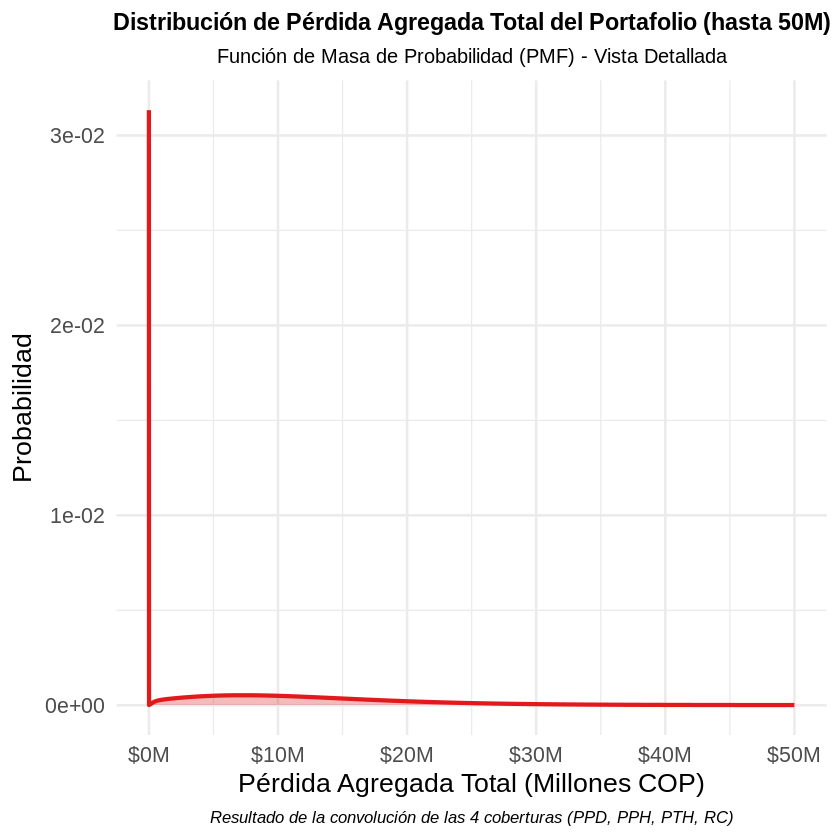

[1] "Gráficos del portafolio total hasta 500M:"


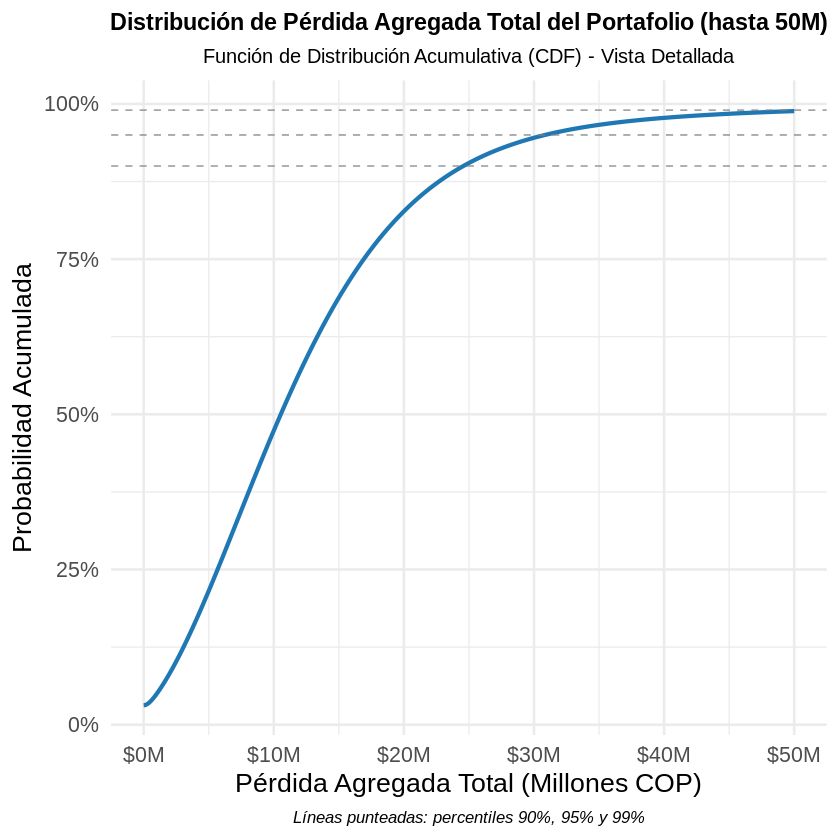

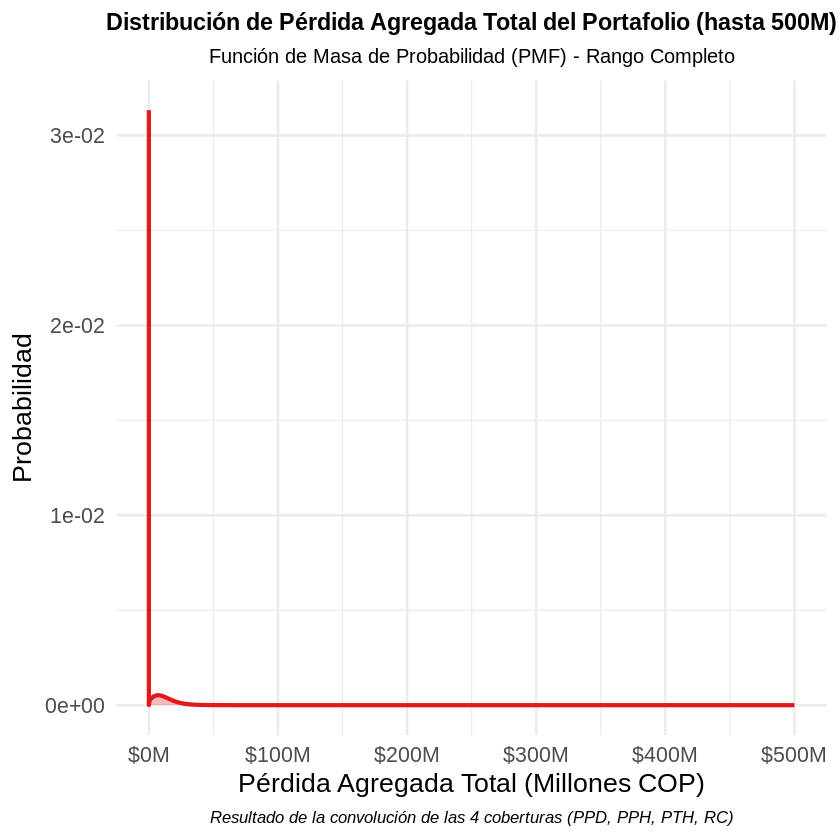

Gráficos del portafolio total guardados (versiones 50M y 500M)\n

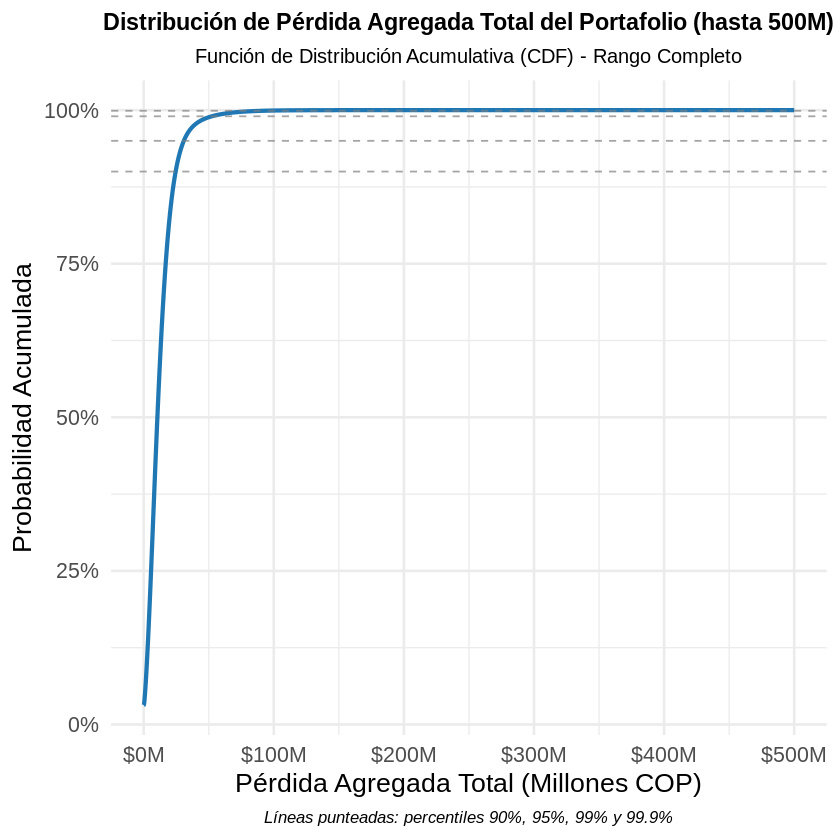

In [20]:
# Preparar datos de la distribución total en dos versiones: hasta 50M y hasta 500M

# VERSIÓN 1: DATOS HASTA 50 MILLONES (DETALLE)
idx_50M <- which(dist_total$x <= 50000000)
if (length(idx_50M) == 0) idx_50M <- 1:min(5000, nrow(dist_total))
datos_total_50M <- dist_total[idx_50M, ]

# VERSIÓN 2: DATOS HASTA 500 MILLONES (RANGO COMPLETO)
idx_500M <- which(dist_total$x <= 500000000)
if (length(idx_500M) == 0) idx_500M <- 1:nrow(dist_total)
datos_total_500M <- dist_total[idx_500M, ]

cat(sprintf("Datos del portafolio total - 50M: %d puntos (hasta $%s), 500M: %d puntos (hasta $%s)\\n", 
           nrow(datos_total_50M), format(max(datos_total_50M$x), big.mark = ","),
           nrow(datos_total_500M), format(max(datos_total_500M$x), big.mark = ",")))

# VERSIÓN 1: GRÁFICOS HASTA 50 MILLONES (DETALLE)

# Gráfico PMF total - 50M
p3_50M <- ggplot(datos_total_50M, aes(x = x, y = pmf)) +
  geom_line(color = "#E31A1C", size = 1.2) +
  geom_area(alpha = 0.3, fill = "#E31A1C") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = scientific) +
  labs(
    title = "Distribución de Pérdida Agregada Total del Portafolio (hasta 50M)",
    subtitle = "Función de Masa de Probabilidad (PMF) - Vista Detallada",
    x = "Pérdida Agregada Total (Millones COP)",
    y = "Probabilidad",
    caption = "Resultado de la convolución de las 4 coberturas (PPD, PPH, PTH, RC)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    plot.caption = element_text(hjust = 0.5, size = 10, face = "italic")
  )

# Gráfico CDF total - 50M
p4_50M <- ggplot(datos_total_50M, aes(x = x, y = cdf)) +
  geom_line(color = "#1F78B4", size = 1.2) +
  geom_hline(yintercept = c(0.90, 0.95, 0.99), 
             linetype = "dashed", color = "gray50", alpha = 0.7) +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Distribución de Pérdida Agregada Total del Portafolio (hasta 50M)",
    subtitle = "Función de Distribución Acumulativa (CDF) - Vista Detallada",
    x = "Pérdida Agregada Total (Millones COP)",
    y = "Probabilidad Acumulada",
    caption = "Líneas punteadas: percentiles 90%, 95% y 99%"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    plot.caption = element_text(hjust = 0.5, size = 10, face = "italic")
  )

# VERSIÓN 2: GRÁFICOS HASTA 500 MILLONES (RANGO COMPLETO)

# Gráfico PMF total - 500M
p3_500M <- ggplot(datos_total_500M, aes(x = x, y = pmf)) +
  geom_line(color = "#E31A1C", size = 1.2) +
  geom_area(alpha = 0.3, fill = "#E31A1C") +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = scientific) +
  labs(
    title = "Distribución de Pérdida Agregada Total del Portafolio (hasta 500M)",
    subtitle = "Función de Masa de Probabilidad (PMF) - Rango Completo",
    x = "Pérdida Agregada Total (Millones COP)",
    y = "Probabilidad",
    caption = "Resultado de la convolución de las 4 coberturas (PPD, PPH, PTH, RC)"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    plot.caption = element_text(hjust = 0.5, size = 10, face = "italic")
  )

# Gráfico CDF total - 500M
p4_500M <- ggplot(datos_total_500M, aes(x = x, y = cdf)) +
  geom_line(color = "#1F78B4", size = 1.2) +
  geom_hline(yintercept = c(0.90, 0.95, 0.99, 0.999), 
             linetype = "dashed", color = "gray50", alpha = 0.7) +
  scale_x_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  scale_y_continuous(labels = percent) +
  labs(
    title = "Distribución de Pérdida Agregada Total del Portafolio (hasta 500M)",
    subtitle = "Función de Distribución Acumulativa (CDF) - Rango Completo",
    x = "Pérdida Agregada Total (Millones COP)",
    y = "Probabilidad Acumulada",
    caption = "Líneas punteadas: percentiles 90%, 95%, 99% y 99.9%"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    plot.caption = element_text(hjust = 0.5, size = 10, face = "italic")
  )

# Mostrar gráficos
print("Gráficos del portafolio total hasta 50M:")
print(p3_50M)
print(p4_50M)

print("Gráficos del portafolio total hasta 500M:")
print(p3_500M)
print(p4_500M)

# Guardar gráficos
ggsave("../data/output/grafico_pmf_total_50M.png", p3_50M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_cdf_total_50M.png", p4_50M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_pmf_total_500M.png", p3_500M, width = 12, height = 8, dpi = 300)
ggsave("../data/output/grafico_cdf_total_500M.png", p4_500M, width = 12, height = 8, dpi = 300)

cat("Gráficos del portafolio total guardados (versiones 50M y 500M)\\n")

## Gráfico comparativo de percentiles

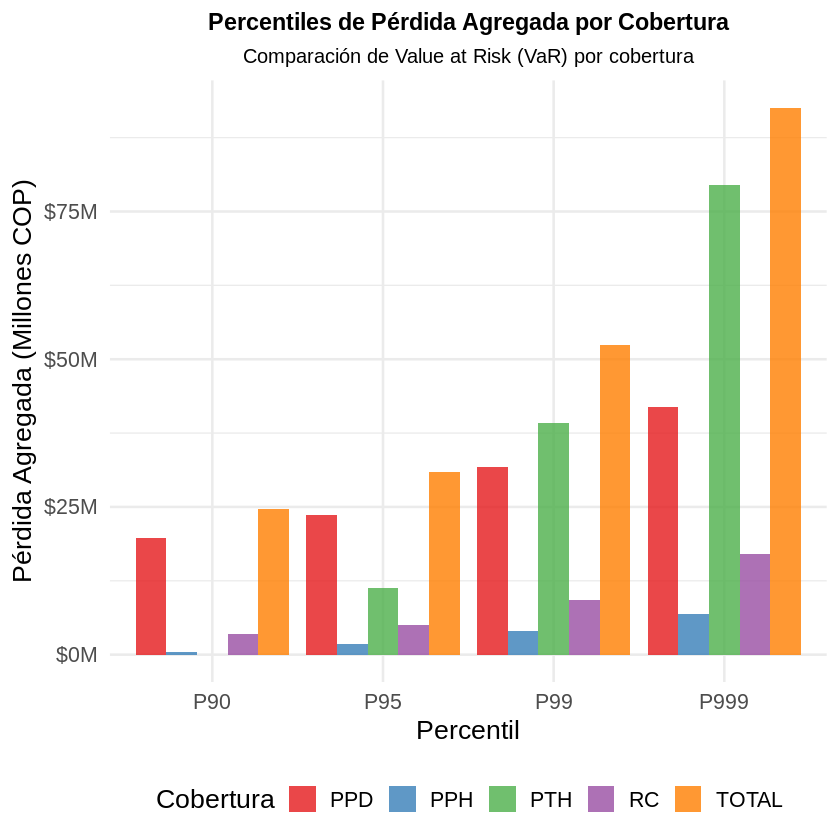

In [21]:
# Preparar datos para gráfico de percentiles
datos_percentiles <- resumen_percentiles %>%
  tidyr::pivot_longer(cols = c(P90, P95, P99, P999), 
                     names_to = "Percentil", 
                     values_to = "Valor") %>%
  mutate(
    Percentil = factor(Percentil, levels = c("P90", "P95", "P99", "P999")),
    Cobertura = factor(Cobertura, levels = c("PPD", "PPH", "PTH", "RC", "TOTAL"))
  )

# Gráfico de barras de percentiles
p5 <- ggplot(datos_percentiles, aes(x = Percentil, y = Valor, fill = Cobertura)) +
  geom_col(position = "dodge", alpha = 0.8) +
  scale_fill_brewer(type = "qual", palette = "Set1") +
  scale_y_continuous(labels = dollar_format(scale = 1e-6, suffix = "M")) +
  labs(
    title = "Percentiles de Pérdida Agregada por Cobertura",
    subtitle = "Comparación de Value at Risk (VaR) por cobertura",
    x = "Percentil",
    y = "Pérdida Agregada (Millones COP)",
    fill = "Cobertura"
  ) +
  theme_minimal(base_size = 16) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 12)
  )

print(p5)

# Guardar gráfico
ggsave("../data/output/grafico_percentiles_comparativo.png", p5, width = 12, height = 8, dpi = 300)

## Gráfico combinado final

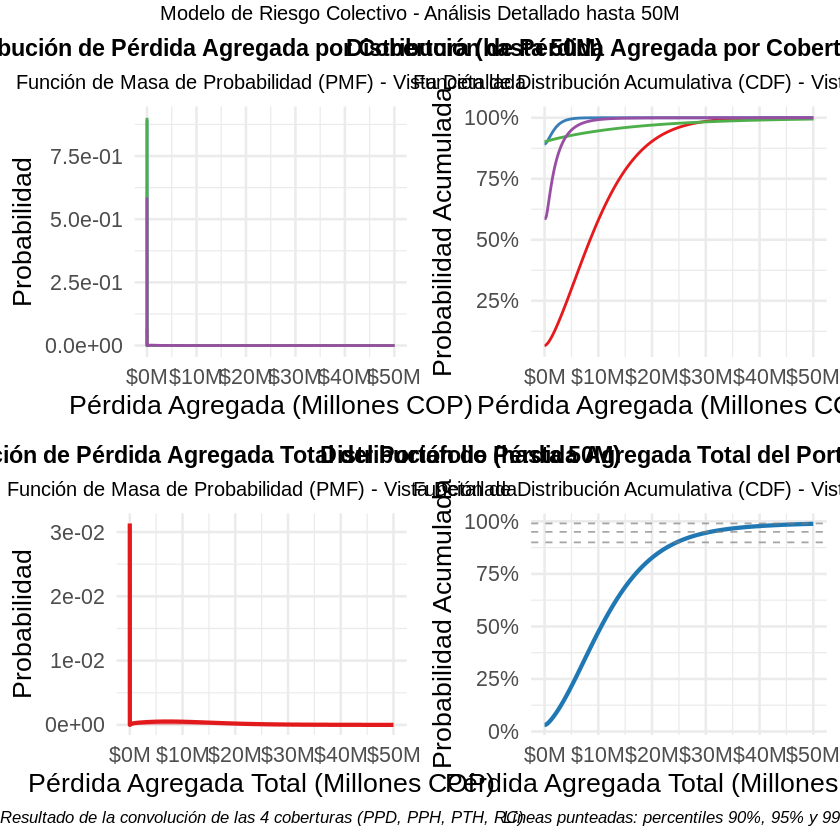

Gráficos combinados guardados:\n- grafico_combinado_50M.png (vista detallada)\n- grafico_combinado_500M.png (rango completo)\n[1] "Gráficos combinados creados"


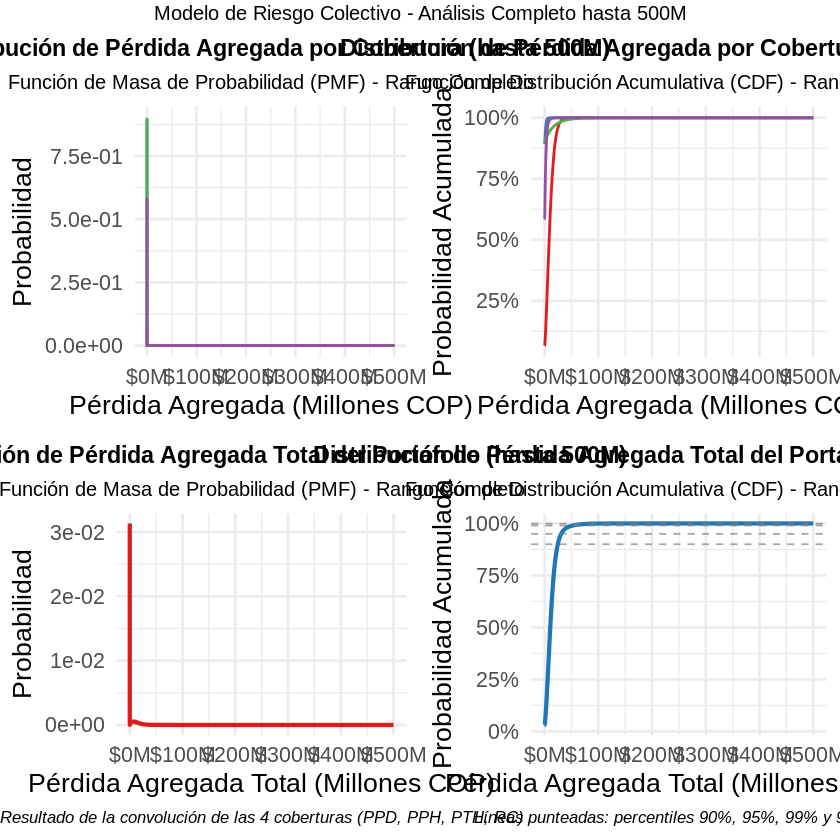

In [22]:
# Crear gráficos combinados: uno para 50M y otro para 500M
layout_matrix <- rbind(c(1, 1, 2, 2),
                      c(1, 1, 2, 2),
                      c(3, 3, 4, 4),
                      c(3, 3, 4, 4))

# VERSIÓN 1: GRÁFICO COMBINADO HASTA 50M (DETALLE)
combined_plot_50M <- grid.arrange(
  p1_50M + theme(legend.position = "none"),
  p2_50M + theme(legend.position = "none"),
  p3_50M,
  p4_50M,
  layout_matrix = layout_matrix,
  top = "Modelo de Riesgo Colectivo - Análisis Detallado hasta 50M"
)

# VERSIÓN 2: GRÁFICO COMBINADO HASTA 500M (RANGO COMPLETO)
combined_plot_500M <- grid.arrange(
  p1_500M + theme(legend.position = "none"),
  p2_500M + theme(legend.position = "none"),
  p3_500M,
  p4_500M,
  layout_matrix = layout_matrix,
  top = "Modelo de Riesgo Colectivo - Análisis Completo hasta 500M"
)

# Guardar gráficos combinados
ggsave("../data/output/grafico_combinado_50M.png", combined_plot_50M, 
       width = 16, height = 12, dpi = 300)
ggsave("../data/output/grafico_combinado_500M.png", combined_plot_500M, 
       width = 16, height = 12, dpi = 300)

cat("Gráficos combinados guardados:\\n")
cat("- grafico_combinado_50M.png (vista detallada)\\n")
cat("- grafico_combinado_500M.png (rango completo)\\n")

print("Gráficos combinados creados")

## Exportar gráficos de validación

Procesando datos de validación FFT vs Panjer...
Gráfico de validación exportado
[1] "Procesamiento de validación completado"


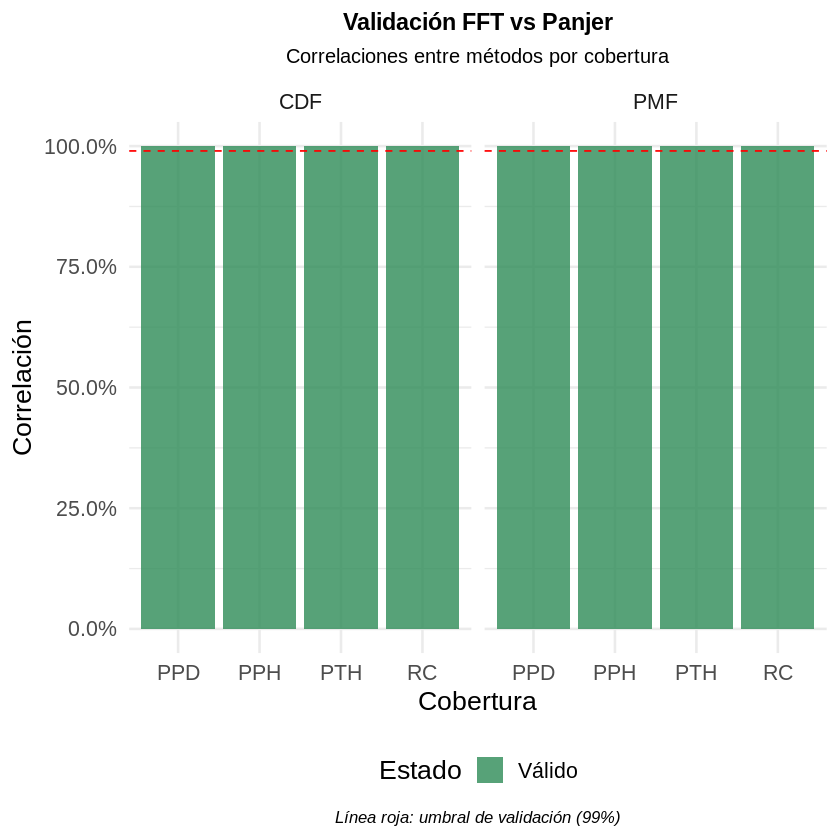

In [23]:
# Cargar datos de validación
cat("Procesando datos de validación FFT vs Panjer...\n")

# Cargar datos de validación si existen
if (file.exists("../data/processed/validacion_fft_panjer_resumen.csv")) {
  validacion_resumen <- read.csv("../data/processed/validacion_fft_panjer_resumen.csv")
  
  # Exportar a output
  write.csv(validacion_resumen, "../data/output/validacion_fft_panjer_resumen.csv", row.names = FALSE)
  
  # Crear gráfico de validación
  p_val <- validacion_resumen %>%
    select(Cobertura, Corr_PMF, Corr_CDF) %>%
    tidyr::pivot_longer(cols = c(Corr_PMF, Corr_CDF), 
                       names_to = "Tipo", 
                       values_to = "Correlacion") %>%
    mutate(
      Tipo = ifelse(Tipo == "Corr_PMF", "PMF", "CDF"),
      Estado = ifelse(Correlacion > 0.99, "Válido", "Inválido")
    ) %>%
    ggplot(aes(x = Cobertura, y = Correlacion, fill = Estado)) +
    geom_col(alpha = 0.8) +
    geom_hline(yintercept = 0.99, linetype = "dashed", color = "red") +
    facet_wrap(~Tipo) +
    scale_fill_manual(values = c("Válido" = "#2E8B57", "Inválido" = "#DC143C")) +
    scale_y_continuous(labels = scales::percent_format(accuracy = 0.1)) +
    labs(
      title = "Validación FFT vs Panjer",
      subtitle = "Correlaciones entre métodos por cobertura",
      x = "Cobertura",
      y = "Correlación",
      fill = "Estado",
      caption = "Línea roja: umbral de validación (99%)"
    ) +
    theme_minimal(base_size = 16) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5, size = 12),
      plot.caption = element_text(hjust = 0.5, size = 10, face = "italic"),
      legend.position = "bottom"
    )
  
  print(p_val)
  ggsave("../data/output/grafico_validacion_fft_panjer.png", p_val, width = 10, height = 8, dpi = 300)
  
  cat("Gráfico de validación exportado\n")
} else {
  cat("Archivo de validación no encontrado. Ejecute validacion_fft_panjer.ipynb primero.\n")
}

print("Procesamiento de validación completado")

## Resumen final

In [24]:
# Mostrar resumen final
cat("\n═══════════════════════════════════════════════════════════════════════════\n")
cat("                              RESUMEN FINAL                                 \n")
cat("═══════════════════════════════════════════════════════════════════════════\n")

cat("ARCHIVOS GENERADOS EN data/output/:\n")
archivos_output <- list.files("../data/output/", full.names = FALSE)
for (archivo in archivos_output) {
  cat(sprintf("  ✓ %s\n", archivo))
}

cat("\nESTADÍSTICAS PRINCIPALES:\n")
cat(sprintf("  • Distribuciones por cobertura: %d puntos cada una\n", nrow(fft_ppd)))
cat(sprintf("  • Distribución total del portafolio: %d puntos\n", nrow(dist_total)))
cat(sprintf("  • Rango individual: $0 - $%s\n", format(max(fft_ppd$x), big.mark = ",")))
cat(sprintf("  • Rango total: $0 - $%s\n", format(max(dist_total$x), big.mark = ",")))
cat(sprintf("  • Percentil 99%% portafolio: $%s\n", format(dist_total$x[which(dist_total$cdf >= 0.99)[1]], big.mark = ",")))

cat("\nGRÁFICOS GENERADOS:\n")
cat("  📊 POR COBERTURA:\n")
cat("    - Versión 50M: grafico_pmf_coberturas_50M.png, grafico_cdf_coberturas_50M.png\n")
cat("    - Versión 500M: grafico_pmf_coberturas_500M.png, grafico_cdf_coberturas_500M.png\n")
cat("  📊 PORTAFOLIO TOTAL:\n")
cat("    - Versión 50M: grafico_pmf_total_50M.png, grafico_cdf_total_50M.png\n")
cat("    - Versión 500M: grafico_pmf_total_500M.png, grafico_cdf_total_500M.png\n")
cat("  📊 COMBINADOS:\n")
cat("    - Vista detallada: grafico_combinado_50M.png\n")
cat("    - Rango completo: grafico_combinado_500M.png\n")
cat("  📊 ADICIONALES:\n")
cat("    - Percentiles: grafico_percentiles_comparativo.png\n")
cat("    - Validación: grafico_validacion_fft_panjer.png\n")

cat("\nMÉTODOS IMPLEMENTADOS:\n")
cat("  ✓ Algoritmo FFT para distribuciones compuestas\n")
cat("  ✓ Algoritmo de Panjer (actuar package)\n")
cat("  ✓ Convolución múltiple para pérdida agregada total\n")
cat("  ✓ Validación cruzada entre métodos\n")
cat("  ✓ Gráficos en dos escalas: detalle (50M) y completo (500M)\n")

cat("\nCOBERTURAS ANALIZADAS:\n")
cat("  • PPD: Pérdida Parcial por Daños\n")
cat("  • PPH: Pérdida Parcial por Hurto\n")
cat("  • PTH: Pérdida Total por Hurto\n")
cat("  • RC: Responsabilidad Civil\n")
cat("  • TOTAL: Convolución de las 4 coberturas\n")

cat("\nUSO DE LOS ARCHIVOS:\n")
cat("  • Archivos CSV: Para análisis adicionales y reportes\n")
cat("  • Gráficos 50M: Para presentaciones (mejor visibilidad)\n")
cat("  • Gráficos 500M: Para análisis completo de colas\n")
cat("  • Resumen de percentiles: Para cálculos de VaR y capital\n")

cat("\nRANGOS DE ANÁLISIS:\n")
cat("  • Gráficos detallados: $0 - $50,000,000 (mejor resolución)\n")
cat("  • Gráficos completos: $0 - $500,000,000 (análisis de colas)\n")
cat("  • Datos exportados: Rango completo sin limitaciones\n")

cat("═══════════════════════════════════════════════════════════════════════════\n")
cat("                   ANÁLISIS COMPLETADO EXITOSAMENTE                         \n")
cat("═══════════════════════════════════════════════════════════════════════════\n")

print("¡Modelo de riesgo colectivo completado con doble escala de análisis!")


═══════════════════════════════════════════════════════════════════════════
                              RESUMEN FINAL                                 
═══════════════════════════════════════════════════════════════════════════
ARCHIVOS GENERADOS EN data/output/:
  ✓ grafico_cdf_coberturas_500M.png
  ✓ grafico_cdf_coberturas_50M.png
  ✓ grafico_cdf_coberturas.png
  ✓ grafico_cdf_total_500M.png
  ✓ grafico_cdf_total_50M.png
  ✓ grafico_cdf_total.png
  ✓ grafico_combinado_500M.png
  ✓ grafico_combinado_50M.png
  ✓ grafico_combinado_final.png
  ✓ grafico_percentiles_comparativo.png
  ✓ grafico_pmf_coberturas_500M.png
  ✓ grafico_pmf_coberturas_50M.png
  ✓ grafico_pmf_coberturas.png
  ✓ grafico_pmf_total_500M.png
  ✓ grafico_pmf_total_50M.png
  ✓ grafico_pmf_total.png
  ✓ grafico_validacion_cdf_fft_panjer.png
  ✓ grafico_validacion_fft_panjer.png
  ✓ metadata_severidad.csv
  ✓ perdida_agregada_ppd.csv
  ✓ perdida_agregada_pph.csv
  ✓ perdida_agregada_pth.csv
  ✓ perdida_agregada_rc.csv
 

  • Rango total: $0 - $2e+09
  • Percentil 99% portafolio: $52,420,000

GRÁFICOS GENERADOS:
  📊 POR COBERTURA:
    - Versión 50M: grafico_pmf_coberturas_50M.png, grafico_cdf_coberturas_50M.png
    - Versión 500M: grafico_pmf_coberturas_500M.png, grafico_cdf_coberturas_500M.png
  📊 PORTAFOLIO TOTAL:
    - Versión 50M: grafico_pmf_total_50M.png, grafico_cdf_total_50M.png
    - Versión 500M: grafico_pmf_total_500M.png, grafico_cdf_total_500M.png
  📊 COMBINADOS:
    - Vista detallada: grafico_combinado_50M.png
    - Rango completo: grafico_combinado_500M.png
  📊 ADICIONALES:
    - Percentiles: grafico_percentiles_comparativo.png
    - Validación: grafico_validacion_fft_panjer.png

MÉTODOS IMPLEMENTADOS:
  ✓ Algoritmo FFT para distribuciones compuestas
  ✓ Algoritmo de Panjer (actuar package)
  ✓ Convolución múltiple para pérdida agregada total
  ✓ Validación cruzada entre métodos
  ✓ Gráficos en dos escalas: detalle (50M) y completo (500M)

COBERTURAS ANALIZADAS:
  • PPD: Pérdida Parcial p